In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Funciones

In [2]:
def word_sentiments(word, tweet_df):
    tweet_batch = tweet_df.loc[tweet_df.loc[:, 'text'].str.contains(fr'\b{word}')].copy()
    
    sentiments = []
    for tweet in tweet_batch['text']:
        sentiments.append(TextBlob(tweet).sentiment.polarity)
    
    tweet_batch['sentiment'] = sentiments
    
    return tweet_batch

In [3]:
def get_companies_transactions(companies, tweets_df, stocks_df, window):
    
    polarities, differences, related_company = [] , [], []
    for company in companies:
        
        tweets = word_sentiments(company, tweets_df)
        company_stocks = stocks_df.loc[stocks_df.loc[:,"name"].str.contains(fr'\b{company.upper()}')].copy()
        
        for _, tweet in tweets.iterrows():
            
            open_ = company_stocks.loc[company_stocks["date"]==tweet.created_at.date(), "open"]
            
            if len(open_) == 0:
                for _, row in company_stocks.iterrows():
                    if row.date.date() > tweet.created_at.date():
                        open_ = company_stocks.loc[company_stocks['date'] == row.date, 'open']
                        break
                        
            close_ = company_stocks.loc[open_.index + window,"close"]
            dif_ = (close_.values - open_.values)/open_.values*100
            
            polarities.append(tweet.sentiment)
            differences.append(dif_)
            related_company.append(company)
            
    plt.xlim((-1, 1))
    plt.ylim((-5, 5))
    plt.scatter(polarities, differences)
    plt.show()
    
    return polarities, differences, related_company

#### Tweets

In [4]:
tweets = pd.read_csv('trump_tweets.csv')

##### Object column to datetime

In [5]:
tweets.loc[:,'created_at'] = pd.to_datetime(tweets.loc[:,'created_at'])

Filtramos las fechas fuera de scope

In [6]:
tweets = tweets.loc[tweets['created_at'] >= datetime.strptime('2017-01-20', "%Y-%m-%d").date()]
tweets = tweets.loc[tweets['created_at'] <= datetime.strptime('2018-08-24', "%Y-%m-%d").date()]

##### To lowercase

In [7]:
tweets['text'] = tweets['text'].str.lower() 

#### Bolsa

In [8]:
bolsa = pd.read_csv('bolsa.csv', index_col=0)
bolsa = bolsa.reset_index(drop=True)

##### Value at open vs value at close

In [9]:
bolsa['difference'] = (bolsa['close'] - bolsa['open'])/(bolsa['open']) * 100

##### Column stating if the values went down 

In [10]:
bolsa['goes_down'] = bolsa['difference'] < 0

##### To datetime

In [11]:
bolsa.loc[:,'date'] = pd.to_datetime(bolsa.loc[:,'date'])

#### Tickers

In [12]:
tickers = pd.read_csv('historical_stocks.csv')

##### Bolsa w/ extended info

In [13]:
bolsa_ext = pd.merge(bolsa, tickers, on=['ticker'])

##### Tweets por cada empresa

In [24]:
empresas = ['amazon', 'facebook', 'general motors', 'toyota', 'alphabet', 'ibm', 'apple', 'microsoft', 'netflix', 'american airlines', 'amd', 'ebay', 'tesla', 'alibaba']

In [21]:
tweet_count = []
tweet_collection = []
for empresa in empresas:
    batch = word_sentiments(empresa, tweets)
    tweet_count.append(len(batch))
    tweet_collection.append(batch)

zipped = list(zip(empresas, tweet_count))

for pair in zipped:
    print(pair)

('amazon', 21)
('facebook', 8)
('general motors', 1)
('toyota', 3)
('alphabet', 0)
('ibm', 0)
('apple', 4)
('microsoft', 0)
('netflix', 0)
('american airlines', 1)
('amd', 0)
('ebay', 0)
('tesla', 0)
('alibaba', 0)
('google', 1)


#### Tweet sentiment

##### Filtering

Necesario eliminar 'APLE'; coincide con APPLE

In [17]:
bolsa_ext = bolsa_ext[~bolsa_ext['ticker'].isin(['APLE'])]

#### Testing

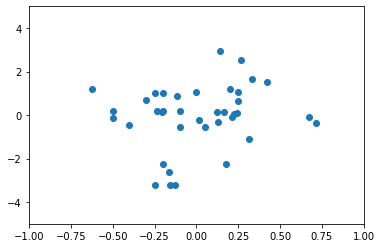

In [25]:
pol, diff, rel =  get_companies_transactions(empresas, tweets, bolsa_ext, window=0)

#### Regresión